# Tutorial: Transcriptome annotation

In this tutorial we will filter and visualize genomic features by read mappability 

Briefly, we will do the following:
- build a transcriptome of canonical protein coding genes (chr20) from gencode annotations
- annotate all gene annotations with a bedgraph file containing umap mappability values.
- Query some of the data and demonstrated the slice_from_parent() functionality
- Visualize some of the data with matplotlib

In [1]:
import os, pathlib, platform
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import traceback
import math
import random

# load rnalib
import rnalib as rna
from rnalib import gi, SEP, display_textarea
plt.rcParams["figure.figsize"] = (20,3)

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

'Running rnalib 0.0.2 on python 3.12.1'

## Test datasets

This notebook as well as rnalib's testing suite use various test resources (genomics data files and indexing structures) that can be created by 
running the rnalib `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. There are two seperate resource sets:

* test_resources: small test datasets that are used by rnalib's test suite
* large_test_resources: larger test files that are needed to demonstrate rnalib under realistic conditions. 

Rnalib knows about the test data directory via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`get_resource(<resource_id>)`. Rnalib will recreate these resources only if they are not found in the provided output folder.


In [2]:
if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)
    display("Creating testdata at {rna.__RNALIB_TESTDATA__ }")
    rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, 
                                 rna.testdata.large_test_resources)
else:
    display(f"Testdata at {rna.__RNALIB_TESTDATA__}")
    display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Testdata at rnalib_testdata/'

In [3]:
# Build subset of human transcriptome (all protein coding genes on chr20, Ensembl canonical only)
t=rna.Transcriptome(
    annotation_gff=rna.get_resource("full_gencode_gff"),
    annotation_flavour='gencode',    
    genome_fa=rna.get_resource("grch38_chr20") ,
    copied_fields=['gene_type', 'tag'],
    load_sequence_data=False,
    feature_filter=rna.TranscriptFilter().
            include_chromosomes({'chr20'}).
            include_gene_types({'protein_coding'}).
            include_tags({'Ensembl_canonical', None})
)
display(t)
# prove that filtering worked
assert {g.chromosome for g in t.genes} == {'chr20'}
assert {g.gene_type for g in t.genes} == {'protein_coding'}
assert all({tx.tag is None or 'Ensembl_canonical' in tx.tag for tx in t.transcripts})

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/546 [00:00<?, ?it/s]

Transcriptome with 546 genes and 1605 tx

Now, we annotate all genes with a numpy array containing the respective mappability values. 
This enables efficient slicing of child-intervals (e.g., transcripts, exons).


In [7]:
#%%timeit -n 1 -r 1
import numpy as np
# Example code that calculates a numpy array containing mappability values for each genomic position of the passed genomic feature (anno).
# The respective values are then saved (pickled) to the given output file
# if the output file already exists, values will be loaded from there istead of recalculating them.

def anno_scores(item, label='mappability'):
    """ 
        Callback method for creating the mappability array by slicing all overlapping intervals.
        loc: genomic interval of the feature that is annotated
        anno: the transcriptome anno dict for this feature (so you can also access any other already existing annotations for this feature)
        scores: list of (loc, score) tuples containing all overlapping locations (loc) and their scores as read from the bedgraph file.
    """
    loc, (anno, mapints) = item
    anno[label]=np.zeros(len(loc)) # create empty array
    for sloc,mapint in mapints:
        anno[label][range(max(loc.start, sloc.start)-loc.start, min(loc.end,sloc.end)+1-loc.start)]=mapint.score # update scores

# to speed things up, we could cache the transcriptome annotations in a pickle file and 
# reload from there if this file exists:
# pkfile=Path(large_test_resources['outdir']) / 'gencode.v39.k24.umap.genes.chr20.pk' 
# if os.path.isfile(pkfile): 
#    t.load_annotations(pkfile) # load from pickle file if existing; use update=True to not lose any previously annotated values 
# ...
# t.save_annotations(pkfile, keys={'mappability'}) # save only the mappability values to disk.

#annotate genes with mappability scores
t.annotate(anno_its=rna.it(rna.get_resource("grch38_umap")), 
           fun_anno=anno_scores,
           feature_types=['gene'])

# show an estimate of the memory consumption (for the whole genome this is ~10GB so it might make sense 
# to calculate mean/median mappability per annotation instead of keeping all values)
print(f"Memory size of the create numpy arrays: {sum([a['mappability'].nbytes for a in t.anno.values() if 'mappability' in a]) / (1000*1000*1000) } GB")

  0%|          | 0/1 [00:00<?, ?it/s]

Memory size of the create numpy arrays: 0.238229856 GB


Now, let's query some data. First, we create a list of the 10 genes with the lowest mean mappability:

In [8]:
low_map_genes = sorted({g.gene_name:np.mean(g.mappability) for g in t.genes}.items(), key=lambda x: x[1])[:10]
display(low_map_genes)

[('GGTLC1', 0.532975871313673),
 ('WFDC11', 0.538971807628524),
 ('FAM209B', 0.5450381679389313),
 ('CSTL1', 0.6424284272587242),
 ('WFDC2', 0.6599320882852292),
 ('DEFB124', 0.6672277841764862),
 ('WFDC10B', 0.6673376208944966),
 ('COMMD7', 0.6785302558316367),
 ('ASIP', 0.744302984914946),
 ('NFS1', 0.7490736008177868)]

Now, let's plot the values for one of those genes:
* we select the 1st transcript of the 1st gene in that list. 
* we slice the respective mappability values from the gene object via 'slice_from_parent'
* we summarize the data by calculating 100 tiles that are assigned the mean mappability (yellow line)
* we also plot a rolling average of the values (blue line). note that there are edge effects.
* we additionally highlight the exons of this gene (red) and plot the rank.

'exon 6, len 310: mean mappability: 0.8290322580645161'

'exon 5, len 114: mean mappability: 0.5526315789473685'

'exon 4, len 113: mean mappability: 0.6371681415929203'

'exon 3, len 128: mean mappability: 0.7734375'

'exon 2, len 210: mean mappability: 0.7523809523809524'

'exon 1, len 171: mean mappability: 0.9590643274853801'

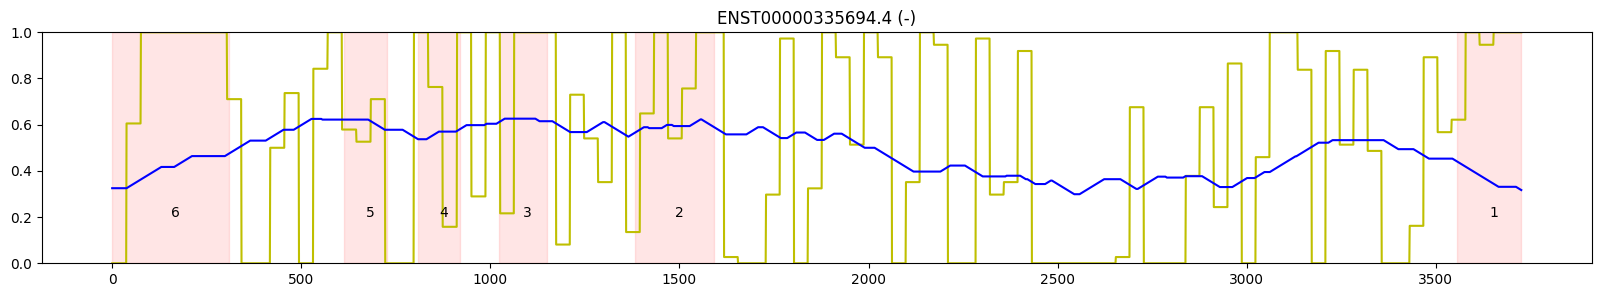

In [9]:
tx = t.gene['GGTLC1'].transcript[0]
map = tx.get('mappability', slice_from_parent=True)
tiled_mean_map = np.concatenate([np.array([np.mean(x)]*len(x)).flatten() for x in 
                                 np.array_split(map, 100)])
roll_mean_map = np.convolve(map, np.ones(1000), mode='same')/1000
assert len(tiled_mean_map)==len(tx) and len(roll_mean_map)==len(tx)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(tiled_mean_map, 'y')
plt.plot(roll_mean_map, 'b-')
plt.title(f"{tx.feature_id} ({tx.strand})")
plt.ylim(0,1)
for ex in sorted(tx.exon): # sort by coordinates
    plt.axvspan(ex.start-tx.start, ex.end-tx.start, color='red', alpha=0.1)
    plt.text(ex.start+(ex.end-ex.start)/2-tx.start, 0.2, ex.rnk)
    display(f"exon {ex.rnk}, len {len(ex)}: mean mappability: {np.mean(ex.get('mappability', slice_from_parent=True))}")

So, exon 5 has the lowest mean mappability of this gene. 
Let's compare exon and intron mappability for all genes.

In [10]:
# NOTE that the bedgraph file does not contain data for chrM and chrY (see tabix -l <file>), 
# so for these we use the default value [] (relevant only for whole-genome analyses)
exon_map = np.concatenate([ex.get('mappability', slice_from_parent=True, default_value=[]) \
                           for ex,_ in t.iterator(feature_types='exon')])
intron_map = np.concatenate([ex.get('mappability', slice_from_parent=True, default_value=[]) \
                           for ex,_ in t.iterator(feature_types='intron')])
print(f"exon mean map: {np.mean(exon_map)}, intron mean map: {np.mean(intron_map)}") 

exon mean map: 0.9771816648134657, intron mean map: 0.9007012130853782


And now, let's plot the mean mappability per feature for all exons and introns.
Introns have lower mappability.

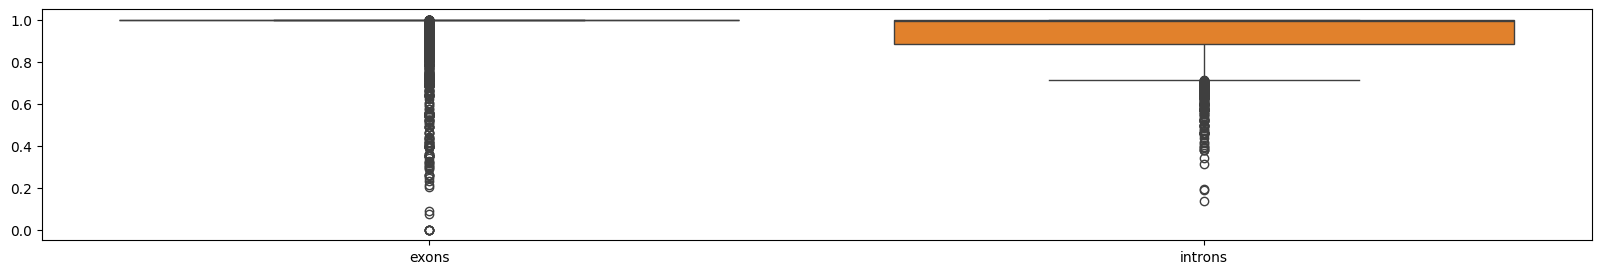

In [11]:
exon_mean_map = {ex:np.mean(ex.get('mappability', default_value=[], slice_from_parent=True)) \
                 for ex,dat in t.iterator(feature_types='exon')}
intron_mean_map = {ex:np.mean(ex.get('mappability', default_value=[], slice_from_parent=True)) \
                 for ex,dat in t.iterator(feature_types='intron')}
_ = sns.boxplot(data={'exons':exon_mean_map.values(), 'introns':intron_mean_map.values()} )

How many exons have zero mappability? What are the respective genes?

In [12]:
# get all exons with 0 mappability 
zero_map_ex=[ex for ex,mean_map in exon_mean_map.items() if mean_map==0]
# now show 10 random genes that contain at least 1 exon with zero mappability
display(f"There are {len(zero_map_ex)}/{len(exon_mean_map)} exons with 0 mappability.")
display(f"Here are the respective gene names: { list({ex.parent.parent.gene_name for ex in zero_map_ex}) }")

'There are 6/11107 exons with 0 mappability.'

"Here are the respective gene names: ['TASP1', 'CSTL1', 'SIRPB1']"

Let's plot all transcripts of this gene (four actually passed the 'Ensembl_canonical' filtering) and
check. Indeed, exon 3 of ENST00000472140.5 has zero mappability...

'ENST00000619238.2 exon 1, len 102: mean mappability: 0.20588235294117646'

'ENST00000619238.2 exon 2, len 91: mean mappability: 0.7692307692307693'

'ENST00000619238.2 exon 3, len 354: mean mappability: 1.0'

'ENST00000347397.5 exon 1, len 122: mean mappability: 1.0'

'ENST00000347397.5 exon 2, len 343: mean mappability: 1.0'

'ENST00000347397.5 exon 3, len 111: mean mappability: 1.0'

'ENST00000347397.5 exon 4, len 160: mean mappability: 1.0'

'ENST00000472140.5 exon 1, len 122: mean mappability: 1.0'

'ENST00000472140.5 exon 2, len 343: mean mappability: 1.0'

'ENST00000472140.5 exon 3, len 42: mean mappability: 0.0'

'ENST00000485969.1 exon 1, len 163: mean mappability: 1.0'

'ENST00000485969.1 exon 2, len 123: mean mappability: 0.08943089430894309'

'ENST00000485969.1 exon 3, len 202: mean mappability: 1.0'

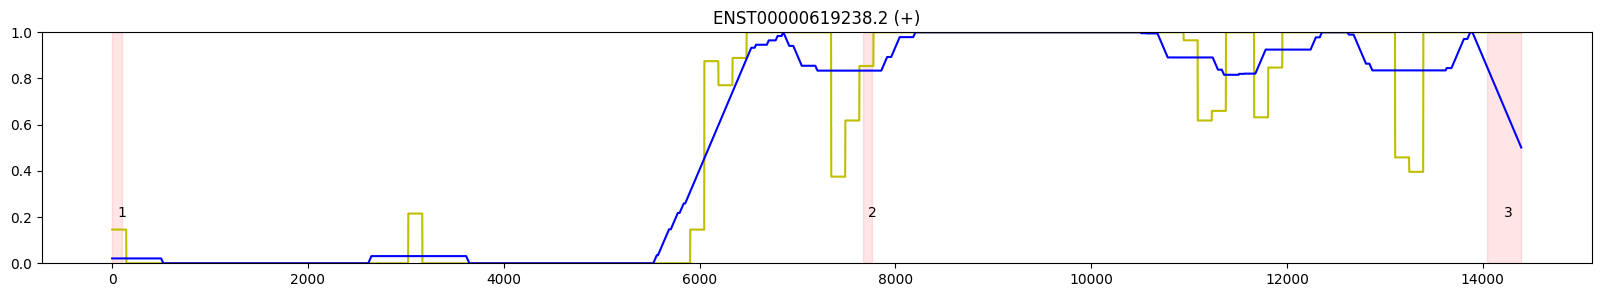

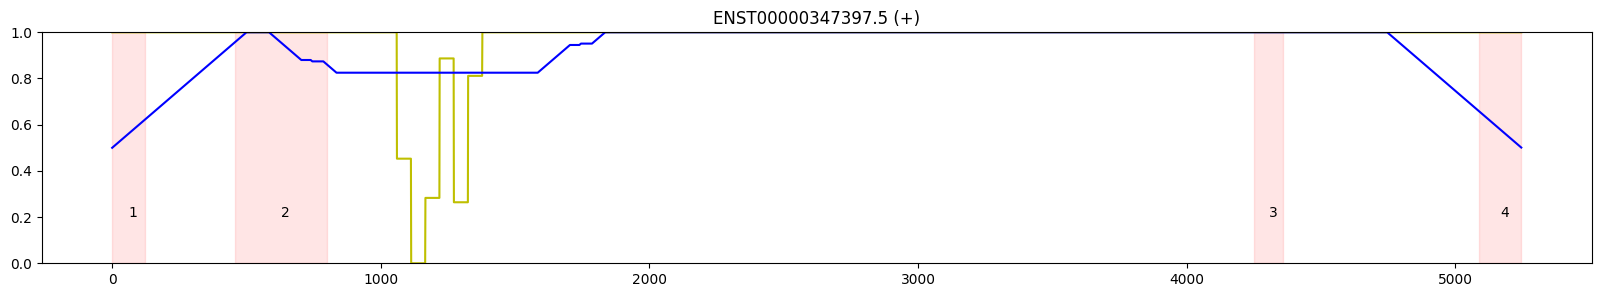

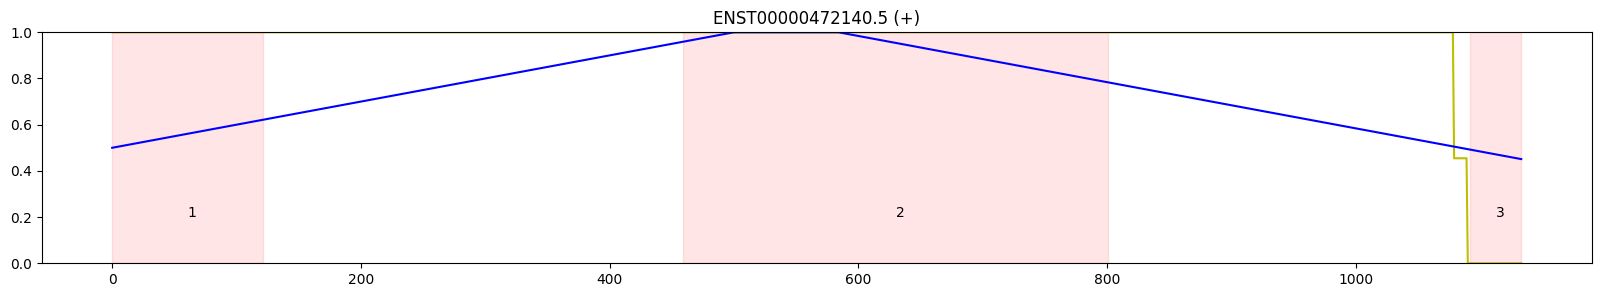

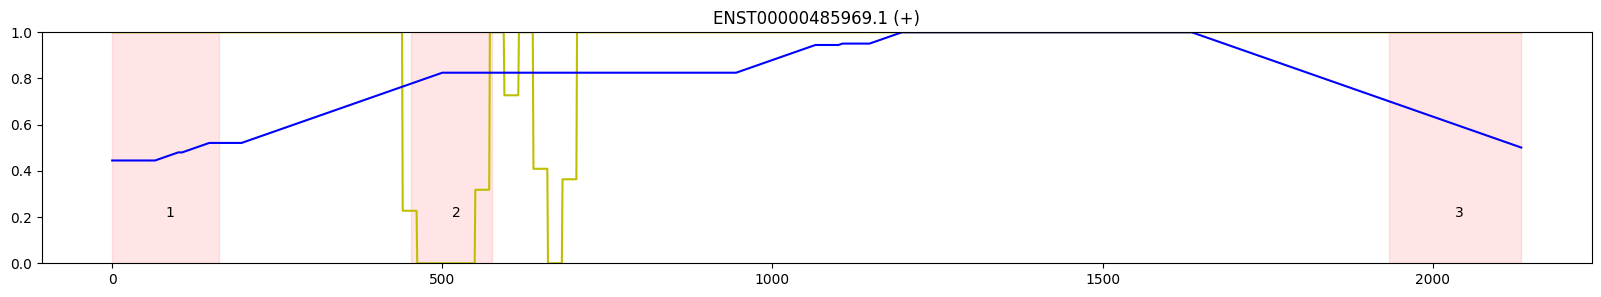

In [13]:
g = t.gene['CSTL1']
for idx,tx in enumerate(g.transcript):
    map = tx.get('mappability', slice_from_parent=True)
    tiled_mean_map = np.concatenate([np.array([np.mean(x)]*len(x)).flatten() for x in 
                                     np.array_split(map, 100)])
    roll_mean_map = np.convolve(map, np.ones(1000), mode='same')/1000
    assert len(tiled_mean_map)==len(tx) and len(roll_mean_map)==len(tx)
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure(idx)
    plt.plot(tiled_mean_map, 'y')
    plt.plot(roll_mean_map, 'b-')
    plt.title(f"{tx.feature_id} ({tx.strand})")
    plt.ylim(0,1)
    for ex in sorted(tx.exon): # sort by coordinates
        plt.axvspan(ex.start-tx.start, ex.end-tx.start, color='red', alpha=0.1)
        plt.text(ex.start+(ex.end-ex.start)/2-tx.start, 0.2, ex.rnk)
        display(f"{tx.feature_id} exon {ex.rnk}, len {len(ex)}: mean mappability: {np.mean(ex.get('mappability', slice_from_parent=True))}")


Finally, lets plot the distribution of mappability values per chromosome as boxplots.

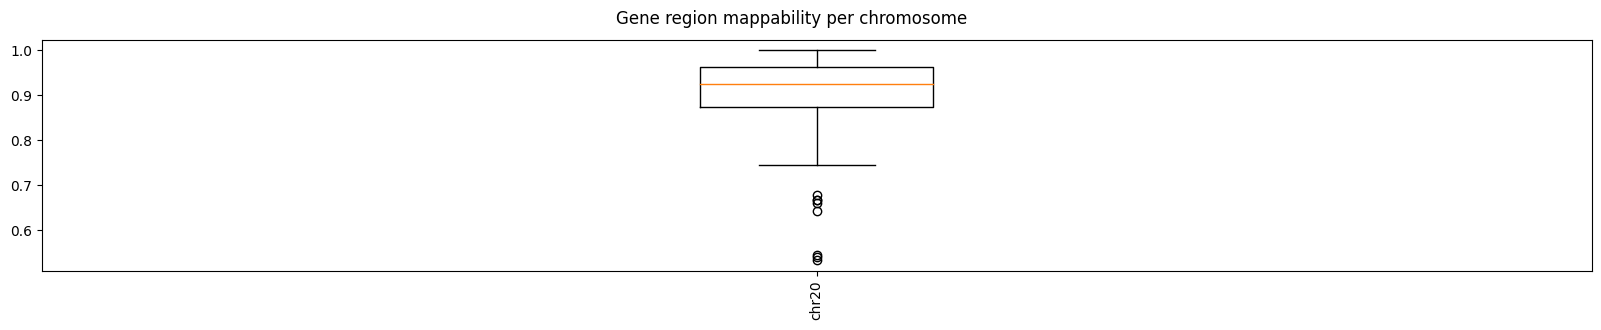

In [14]:
# calculate mean mappability per gene and chromosome 
mean_map=[[np.mean(g.get('mappability',[0])) for g in t.genes if g.chromosome==c] for c in t.merged_refdict]
_=plt.boxplot(mean_map)
_=plt.xticks([x+1 for x in range(len(t.merged_refdict))], list(t.merged_refdict.keys()), rotation=90)
_=plt.suptitle("Gene region mappability per chromosome")